In [1]:
from minimal_model import competitive_oxidation, ref_parameters, REF_STEADY_STATE_VALUES
import scipy.optimize as opt
import numpy as np


In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 10, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 5, 'capthick': 2, 'elinewidth': 2, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['lightsteelblue', 'steelblue']

# Colors to highlight metabolites
# Glucose, lactate, 3HB, Fatty acids
colors_met = ['firebrick', 'lightcoral', 'gold' ,  'wheat',]

In [3]:
# Insulin secretion
k = 3.4
C = 2.3

#Ref. insulin
Imax = 1.0
I0 = abs(1.0)**k / (abs(1.0)**k + C**k)

p = ref_parameters()    

# Reference concentrations
# L, G, F, K, I
x0 = np.array([1, 1, 1, 1, I0])
v0 = competitive_oxidation(x0, p)

In [4]:
# Vary each concentration by 4 fold up and down and calculate the corresponding oxidation rates

# Oxidation rates 
rate_names = ['Lactate', 'Glucose', 'Fatty acids', 'Ketones','Glycolysis']

X = np.logspace(-1, 1, 101)

results = {}

h_g = 1.0
h_f = 1.0
h_l = 1.0
h_k = 1.0

# Glucose
results['Glucose'] = []
for xi in X:
    x = x0.copy()
    x[1] = xi
    v = competitive_oxidation(x, p,)
    results['Glucose'].append({n:v[j] for j,n in enumerate(rate_names)})

# Lactate
results['Lactate'] = []
for xi in X:
    x = x0.copy()
    x[0] = xi
    v = competitive_oxidation(x, p, )
    results['Lactate'].append({n:v[j] for j,n in enumerate(rate_names)})

# Fatty acids
results['Fatty acids'] = []
for xi in X:
    x = x0.copy()
    x[2] = xi

    v = competitive_oxidation(x, p, )
    results['Fatty acids'].append({n:v[j] for j,n in enumerate(rate_names)})

# Ketones
results['Ketones'] = []
for xi in X:
    x = x0.copy()
    x[3] = xi
    v = competitive_oxidation(x, p,)
    results['Ketones'].append({n:v[j] for j,n in enumerate(rate_names)})

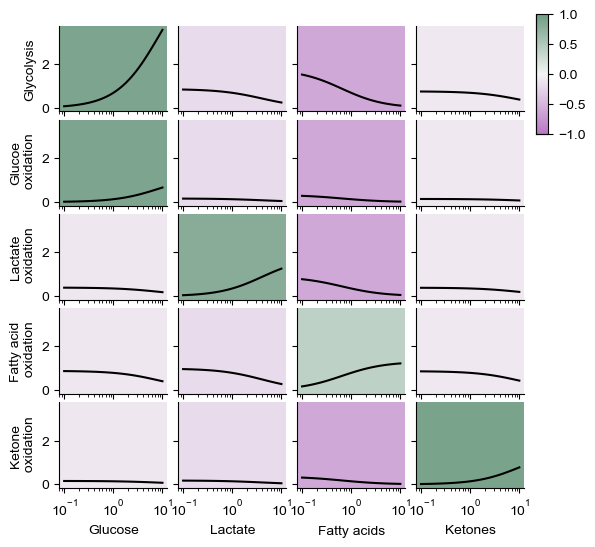

In [5]:
# Plot results in a 4 by 4 grid with oxidation rates on the y-axis and metabolite concentrations on the x-axis
# minimal margins
fig, axs = plt.subplots(5, 4, figsize=(6, 6), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

order_cols = ['Glucose','Lactate', 'Fatty acids', 'Ketones']
order_rows = ['Glycolysis','Glucose', 'Lactate', 'Fatty acids', 'Ketones']

# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2200*0.8
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 


cmap = sns.diverging_palette(22, 220, as_cmap=True)
cmap = sns.diverging_palette(300,145, s=60, as_cmap=True)


scaling = {'Glucose': 6, 'Lactate': 3, 'Fatty acids': 16, 'Ketones': 4, 'Glycolysis': 6}

epsilon = np.zeros((5,4))

for j, met in enumerate(order_cols):
    for i, rate in enumerate(order_rows):
        data = results[met]
        r = np.array([d[rate] for d in data])  * vE  * scaling[rate] / 1000
        axs[i, j].plot(X, r, color='k')
        axs[i, j].set_xscale('log',)
        # Y-ticks 

        if j == 0 and i >= 1:
            # Remove the trailing s if present
            rate_name = rate.replace('s', '')
            axs[i, j].set_ylabel(rate_name + '\n oxidation',fontsize=10, )
        if j == 0 and i == 0:
            axs[i, j].set_ylabel(rate  ,fontsize=10 ,)
        if i == 4:
            axs[i, j].set_xlabel(met, fontsize=10)

        # Color background based on slope at reference concentrations
        epsilon[i,j] = (data[51][rate] - data[49][rate] )/(X[51] - X[49]) * X[50] /data[50][rate]

        #facecolor = cmap(epsilon[i,j])
        # vmin = -1.0, vmax = 1.0
        scaled_epsilon = (epsilon[i,j] + 1.0) / 2.0
        facecolor = cmap(scaled_epsilon)
        axs[i, j].set_facecolor(facecolor)      
        axs[i, j].patch.set_alpha(0.8)  

        # # Annotate with epsilon
        # axs[i, j].annotate(f'{epsilon[i,j]:.1f}', (0.2, 0.8), 
        #                    xycoords='axes fraction', ha='center', va='center', fontsize=10)


# Add a small colorbar in the right corner
cbar_ax = fig.add_axes([0.92, 0.7, 0.02, 0.2])
norm = plt.Normalize(vmin=-1.0, vmax=1.0)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, alpha=0.8)
# Label vertically with fontsize 12
#cbar.set_label(' Sensitivty \n $\\frac{\partial ln v_i}{\partial ln x_j}$', fontsize=14, rotation=0, labelpad=30)
# Y-ticks

sns.despine()

# Save figure
plt.savefig('./output/competitive_catabolism.svg', bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

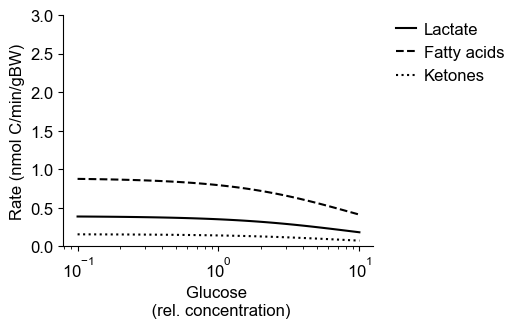

In [6]:
# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Save figure
plt.savefig('./output/competitive_catabolism_glucose_1.svg', bbox_inches='tight')

# Save data to a csv file


order_rows = ['Glycolysis','Glucose', 'Lactate', 'Fatty acids', 'Ketones']


# Plot the glycolysis and glucose oxidation rates in a separate figure
fig, axs = plt.subplots(1, 1, figsize=(4, 3) )

# Glucose oxidation
data = results['Glucose']
r = np.array([d['Lactate'] for d in data])  * vE  * scaling['Lactate'] / 1000
axs.plot(X, r, color='k')

# Glycolysis
data = results['Glucose']
r = np.array([d['Fatty acids'] for d in data])  * vE  * scaling['Fatty acids'] / 1000
axs.plot(X, r, color='k', linestyle='--')

data = results['Glucose']
r = np.array([d['Ketones'] for d in data])  * vE  * scaling['Ketones'] / 1000
axs.plot(X, r, color='k', linestyle=':')

axs.set_xscale('log',)
# Y-ticks
axs.set_ylabel('Rate (nmol C/min/gBW)',fontsize=12, )
axs.set_xlabel('Glucose \n (rel. concentration)', fontsize=12)

axs.set_ylim(0, 3)


# Legend
axs.legend(['Lactate', 'Fatty acids', 'Ketones'], loc='upper left', fontsize=12,
              bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False,  handlelength=1.2, handletextpad=0.5)

sns.despine()

# Save figure
plt.savefig('./output/competitive_catabolism_glucose_2.svg', bbox_inches='tight')
# Save data to a csv file


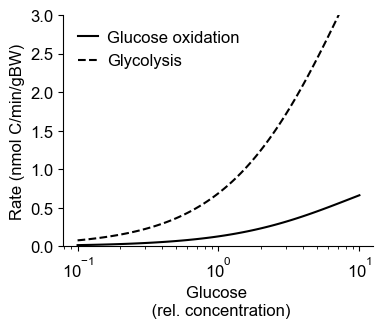

In [7]:
# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Plot the glycolysis and glucose oxidation rates in a separate figure
fig, axs = plt.subplots(1, 1, figsize=(4, 3) )


# Glucose oxidation
data = results['Glucose']
r = np.array([d['Glucose'] for d in data])  * vE  * scaling['Glucose'] / 1000
axs.plot(X, r, color='k')

# Glycolysis
data = results['Glucose']
r = np.array([d['Glycolysis'] for d in data])  * vE  * scaling['Glycolysis'] / 1000
axs.plot(X, r, color='k', linestyle='--')

axs.set_xscale('log',)
# Y-ticks
axs.set_ylabel('Rate (nmol C/min/gBW)',fontsize=12, )
axs.set_xlabel('Glucose \n (rel. concentration)', fontsize=12)

# Legend
axs.legend(['Glucose oxidation', 'Glycolysis'], loc='upper left', fontsize=12,
            frameon=False, handlelength=1.2, handletextpad=0.5)

# Ylim
axs.set_ylim(0, 3)

sns.despine()

# Save figure
plt.savefig('./output/competitive_catabolism_glucose_1.svg', bbox_inches='tight')
# Save data to a csv file

In [8]:
# Make a heat map for epsilon
epsilon


array([[ 0.89622097, -0.19869065, -0.6078915 , -0.08942555],
       [ 0.89622097, -0.19869065, -0.6078915 , -0.08942555],
       [-0.10358208,  0.80097167, -0.6078915 , -0.08942555],
       [-0.10358208, -0.19869065,  0.39160331, -0.08942555],
       [-0.10358208, -0.19869065, -0.6078915 ,  0.91040174]])

In [9]:
# Load concentration data from perubative infusions
df = pd.read_csv('./../perturbative_infusions/output/concentration_data.csv')

# Rename Trcers and compounds
rename_dict = { '3-hydroxybutyrate': '3HB', 
               'glucose': 'Glucose', 'lactate': 'Lactate', }

# Rename values in columns COMPOUND and TRACER
df['COMPOUND'] = df['COMPOUND'].replace(rename_dict)
df['TRACER'] = df['TRACER'].replace(rename_dict)

# Average over commpound == c16:0 , c18:2 and c18:1 --> fatty acids
mapping_dict = {'c16:0': 'Fatty acids', 'c18:2 ': 'Fatty acids', 'c18:1': 'Fatty acids'} 
df['COMPOUND'] = df['COMPOUND'].replace(mapping_dict)

df = df.groupby(['TRACER', 'COMPOUND' ,'CAGE','DAY']).mean().reset_index()


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_64447/3657002781.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['TRACER', 'COMPOUND' ,'CAGE','DAY']).mean().reset_index()


In [10]:
# Fcric data 
df_fcirc = pd.read_csv('./../perturbative_infusions/output/fcirc_data.csv')

# Rename Trcers and compounds
rename_dict = { '3-hydroxybutyrate': '3HB', 
               'glucose': 'Glucose', 'lactate': 'Lactate', }
# Rename values in columns COMPOUND and TRACER
df_fcirc['COMPOUND'] = df_fcirc['COMPOUND'].replace(rename_dict)
df_fcirc['TRACER_x'] = df_fcirc['TRACER_x'].replace(rename_dict)



In [ ]:
# Plot concentration change against fluxes
df_joined = df.merge(df_fcirc, left_on=['TRACER', 'COMPOUND','CAGE','TIME','DAY'], 
                     right_on=['TRACER_x', 'COMPOUND','CAGE','TIME','DAY'], how='inner')

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_64447/2085316499.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TRACER_y'} in the result is deprecated and will raise a MergeError in a future version.
  df_joined = df.merge(df_fcirc, left_on=['TRACER', 'COMPOUND','CAGE','TIME','DAY'],


In [12]:
df_joined

,TRACER_x,COMPOUND,CAGE,DAY,value_x,TIME,TRACER_UMOL_MIN_x,COUNTS_x,MEAN_NON_PERTURBATIVE_DAY1,value_normalized,...,TRACER_UMOL_MIN_y,COUNTS_y,RA,RD,CO2_FLUX_NORM,TRACER_y,DELTA_RD,DELTA_RA,DELTA_RD_norm,DELTA_CO2_FLUX
0,3HB,3HB,3,non-perturbative,1.693216e+07,120.0,0.40160,1449.0,1.950487e+07,0.868099,...,0.40160,1449.0,1.610217,2.011817,1.353386,3-hydroxybutyrate,NaN,NaN,NaN,NaN
1,3HB,3HB,3,perturbative,2.264286e+08,120.0,12.04800,599.0,1.950487e+07,11.608826,...,12.04800,599.0,1.885347,13.933347,9.600861,3-hydroxybutyrate,11.921529,0.275129,11.921529,8.247475
2,3HB,3HB,6,non-perturbative,1.896687e+07,120.0,0.43200,1449.0,1.950487e+07,0.972417,...,0.43200,1449.0,2.242877,2.674877,1.801951,3-hydroxybutyrate,NaN,NaN,NaN,NaN
3,3HB,3HB,6,perturbative,2.142327e+08,120.0,12.96000,599.0,1.950487e+07,10.983548,...,12.96000,599.0,2.061773,15.021773,8.978768,3-hydroxybutyrate,12.346896,-0.181104,12.346896,7.176817
4,3HB,3HB,11,non-perturbative,2.662891e+07,120.0,0.38720,1449.0,1.950487e+07,1.365244,...,0.38720,1449.0,3.175529,3.562729,2.111776,3-hydroxybutyrate,NaN,NaN,NaN,NaN
5,3HB,3HB,11,perturbative,2.805573e+08,120.0,11.61600,599.0,1.950487e+07,14.383964,...,11.61600,599.0,1.802172,13.418172,7.355477,3-hydroxybutyrate,9.855442,-1.373358,9.855442,5.243701
6,Glucose,Glucose,1,non-perturbative,2.773125e+07,120.0,2.04120,1449.0,2.342607e+07,1.183778,...,2.04120,1449.0,13.048581,15.089781,8.589859,glucose,NaN,NaN,NaN,NaN
7,Glucose,Glucose,1,perturbative,5.619516e+07,120.0,29.30580,599.0,2.342607e+07,2.398830,...,29.30580,599.0,5.309542,34.615342,20.181990,glucose,19.525561,-7.739039,19.525561,11.592131
8,Glucose,Glucose,4,non-perturbative,2.535035e+07,120.0,2.17560,1449.0,2.342607e+07,1.082143,...,2.17560,1449.0,14.893671,17.069271,12.085990,glucose,NaN,NaN,NaN,NaN
9,Glucose,Glucose,4,perturbative,5.810186e+07,120.0,31.23540,599.0,2.342607e+07,2.480222,...,31.23540,599.0,5.910742,37.146142,22.269363,glucose,20.076871,-8.982929,20.076871,10.183373


In [13]:
# Rescale concentration by mean level of respective metabolite

concentration_scaling = {'Glucose':5.5, 'Lactate':0.7, "3HB":0.5}

df_joined['concentration_mM'] = df_joined.apply(lambda x: x['value_normalized'] * concentration_scaling[x['COMPOUND']] ,axis=1)

concentration_scaling = {'Glucose':5.5, 'Lactate':0.7, "Ketones":0.5}


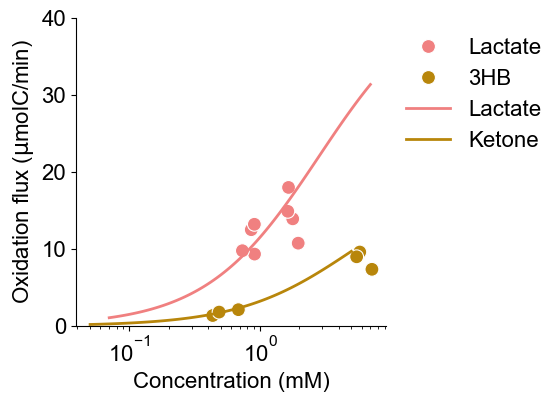

In [14]:
# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})

colors_met = [ 'lightcoral', 'darkgoldenrod',]

# Rename labels glucose, lactate, 3HB
order = [ 'Lactate', '3HB', ] 

df_joined_temp = df_joined[df_joined['COMPOUND'].isin(order)]

# Scatter plot of delta RD and delta CO2 flux
f, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=df_joined_temp, x='concentration_mM', y='CO2_FLUX_NORM' ,
                hue='COMPOUND', 
                palette=colors_met, s=100, hue_order=order, )
# Plot the model 

order = ['Lactate', 'Ketones', ]


for i, met in enumerate(order):
    # Get the data for the current metabolite
    data = results[met]
    if met == 'Glucose':
        # Plot the model
        r1 = np.array([d[met] for d in data])  * vE  * scaling[met] / 1000 * 25
        r2 = np.array([d['Glycolysis'] for d in data])  * vE  * scaling['Glycolysis'] / 1000 * 25
        ax.plot(X * concentration_scaling[met], r1 + r2, color=colors_met[i],  linewidth=2, label='Glycolysis & \nGlucose oxidation')

    elif met == 'Ketones':
        # Plot the model
        r = np.array([d[met] for d in data])  * vE  * scaling[met] / 1000 * 25
        ax.plot(X * concentration_scaling[met], 0.5 * r, color=colors_met[i],  linewidth=2, label='Ketone',)
        #ax.plot(X, r*0.5, color=colors_met[i],  linewidth=2, linestyle='--', )

    else:
        # Plot the model
        r = np.array([d[met] for d in data])  * vE  * scaling[met] / 1000 * 25
        ax.plot(X * concentration_scaling[met], r, color=colors_met[i],  linewidth=2, label=met)

plt.ylim(0, 40)

sns.despine()
plt.xscale('log')
plt.xlabel('Concentration (mM)')
plt.ylabel('Oxidation flux ($\mathrm{\mu}$molC/min)')

plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.savefig('./output/concentration_CO2_flux_ketone_lactate.svg',  bbox_inches='tight')

# Save the data 

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_64447/2587418245.py:12: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.scatterplot(data=df_joined_temp, x='concentration_mM', y='RD' ,


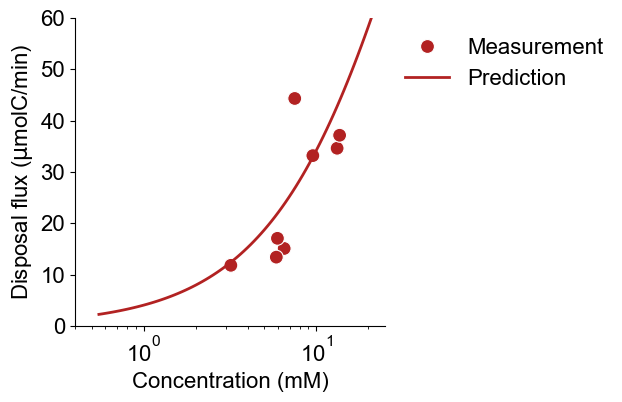

In [15]:
# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})

colors_met = ['firebrick', 'lightcoral', 'darkgoldenrod',]

# Rename labels glucose, lactate, 3HB
order = ['Glucose', ] 

df_joined_temp = df_joined[df_joined['COMPOUND'].isin(order)]
# Scatter plot of delta RD and delta CO2 flux
f, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=df_joined_temp, x='concentration_mM', y='RD' ,
                hue='COMPOUND', 
                palette=colors_met, s=100, hue_order=order, )
# Plot the model 

order = ['Glucose', ]

for i, met in enumerate(order):
    # Get the data for the current metabolite
    data = results[met]
    if met == 'Glucose':
        # Plot the model
        r1 = np.array([d[met] for d in data])  * vE  * scaling[met] / 1000 * 25
        r2 = np.array([d['Glycolysis'] for d in data])  * vE  * scaling['Glycolysis'] / 1000 * 25
        ax.plot(X * concentration_scaling[met], r1 + r2, color=colors_met[i],  linewidth=2, label='Prediction')


plt.ylim(0, 60)
plt.xlim(4e-1, 25)

# Rename first legen entry:
handles, labels = ax.get_legend_handles_labels()
new_labels = labels.copy()
new_labels[0] = 'Measurement'



sns.despine()
plt.xscale('log')
plt.xlabel('Concentration (mM)')
plt.ylabel('Disposal flux ($\mathrm{\mu}$molC/min)')

plt.legend(handles, new_labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.savefig('./output/concentration_RD_flux.svg',  bbox_inches='tight')

# Save the data 

In [16]:
new_labels

['Measurement', 'Prediction']

In [17]:
# Compute mean error between model and data for CO2 and RD
c_order = ['Glucose', 'Lactate', 'Fatty acids','3HB',]

# Map tracer to model 
tracer_mapping = {
    'Glucose': 'Glucose',
    'Lactate': 'Lactate',
    'Fatty acids': 'Fatty acids',
    '3HB': 'Ketones',
}

KI_F = 0.25
v_in_F = 0.01
p_fited = ref_parameters( KI_F = KI_F)

# Compute the fluxes using the relative concentrations as input data
results = []
index = []
for g in df.groupby(['TRACER','CAGE','DAY']).groups:
    # Get the data for the current group
    data = df.groupby(['TRACER','CAGE','DAY']).get_group(g)
    data.index = data.COMPOUND 

    x = data.loc[c_order,'value_normalized'].values 

    # Compute insulin value
    Imax = 1.0
    G = data.loc['Glucose','value_normalized'] 
    I = abs(G)**k / (abs(G)**k + C**k)
    
    # Insulin == I0 
    #I = I0 

    x = np.append(x, I)

    # x -> data
    v = competitive_oxidation(x, p,)
    # 
    v = pd.Series(v, index=rate_names) * vE / 1000 * 25 # -> 25g Mouse 

    if g[0] == 'Glucose':
        # Glucose oxidation
        r1 = v['Glucose'] * scaling[met] 
        # Lactate oxidstion
        r2 = v['Lactate'] * scaling['Lactate'] 

        #r2 = v['Glycolysis'] * scaling[met] 
        # Total glucose oxidation
        results.append(r1 + r2)
    elif g[0] == '3HB':
        # Ketone oxidation
        r = v['Ketones'] * scaling[met] 
        results.append(r*0.5)
    else:
        # Other oxidation
        r = v[g[0]] * scaling[met] 
        results.append(r)

    # index g 
    index.append(g)


# Convert to dataframe
df_results = pd.DataFrame(results)
df_results.columns = ['predicted_flux']
# Add columns for G 
df_results['TRACER'] = [i[0] for i in index]
df_results['CAGE'] = [i[1] for i in index]
df_results['DAY'] = [i[2] for i in index]


In [18]:
data.loc[c_order,'value_normalized']

COMPOUND
Glucose        0.921545
Lactate        2.800027
Fatty acids    1.043509
3HB            0.413197
Name: value_normalized, dtype: float64

In [19]:
df_joined


,TRACER_x,COMPOUND,CAGE,DAY,value_x,TIME,TRACER_UMOL_MIN_x,COUNTS_x,MEAN_NON_PERTURBATIVE_DAY1,value_normalized,...,COUNTS_y,RA,RD,CO2_FLUX_NORM,TRACER_y,DELTA_RD,DELTA_RA,DELTA_RD_norm,DELTA_CO2_FLUX,concentration_mM
0,3HB,3HB,3,non-perturbative,1.693216e+07,120.0,0.40160,1449.0,1.950487e+07,0.868099,...,1449.0,1.610217,2.011817,1.353386,3-hydroxybutyrate,NaN,NaN,NaN,NaN,0.434050
1,3HB,3HB,3,perturbative,2.264286e+08,120.0,12.04800,599.0,1.950487e+07,11.608826,...,599.0,1.885347,13.933347,9.600861,3-hydroxybutyrate,11.921529,0.275129,11.921529,8.247475,5.804413
2,3HB,3HB,6,non-perturbative,1.896687e+07,120.0,0.43200,1449.0,1.950487e+07,0.972417,...,1449.0,2.242877,2.674877,1.801951,3-hydroxybutyrate,NaN,NaN,NaN,NaN,0.486208
3,3HB,3HB,6,perturbative,2.142327e+08,120.0,12.96000,599.0,1.950487e+07,10.983548,...,599.0,2.061773,15.021773,8.978768,3-hydroxybutyrate,12.346896,-0.181104,12.346896,7.176817,5.491774
4,3HB,3HB,11,non-perturbative,2.662891e+07,120.0,0.38720,1449.0,1.950487e+07,1.365244,...,1449.0,3.175529,3.562729,2.111776,3-hydroxybutyrate,NaN,NaN,NaN,NaN,0.682622
5,3HB,3HB,11,perturbative,2.805573e+08,120.0,11.61600,599.0,1.950487e+07,14.383964,...,599.0,1.802172,13.418172,7.355477,3-hydroxybutyrate,9.855442,-1.373358,9.855442,5.243701,7.191982
6,Glucose,Glucose,1,non-perturbative,2.773125e+07,120.0,2.04120,1449.0,2.342607e+07,1.183778,...,1449.0,13.048581,15.089781,8.589859,glucose,NaN,NaN,NaN,NaN,6.510776
7,Glucose,Glucose,1,perturbative,5.619516e+07,120.0,29.30580,599.0,2.342607e+07,2.398830,...,599.0,5.309542,34.615342,20.181990,glucose,19.525561,-7.739039,19.525561,11.592131,13.193567
8,Glucose,Glucose,4,non-perturbative,2.535035e+07,120.0,2.17560,1449.0,2.342607e+07,1.082143,...,1449.0,14.893671,17.069271,12.085990,glucose,NaN,NaN,NaN,NaN,5.951785
9,Glucose,Glucose,4,perturbative,5.810186e+07,120.0,31.23540,599.0,2.342607e+07,2.480222,...,599.0,5.910742,37.146142,22.269363,glucose,20.076871,-8.982929,20.076871,10.183373,13.641223


In [20]:
# Join with the flux data
df_joined = df_results.merge(df_fcirc, left_on=['TRACER', 'CAGE','DAY'], 
                     right_on=['TRACER_x', 'CAGE','DAY'], how='inner')

# Drop duplicated columns 
duplicaated_cols = df_joined.columns.duplicated()
df_joined = df_joined.loc[:, ~duplicaated_cols]



/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_64447/1206964240.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TRACER_y'} in the result is deprecated and will raise a MergeError in a future version.
  df_joined = df_results.merge(df_fcirc, left_on=['TRACER', 'CAGE','DAY'],


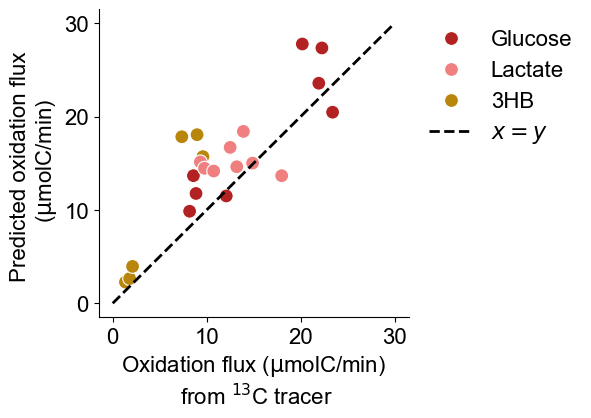

In [21]:
# Truthplot 
order = ['Glucose', 'Lactate','3HB']

f, ax = plt.subplots(1, 1, figsize=(4, 4))
# Scatter plot of delta RD and delta CO2 flux
sns.scatterplot(data=df_joined, x='CO2_FLUX_NORM', y='predicted_flux' ,
                hue='TRACER_x', 
                palette=colors_met, s=100, hue_order=order, )

# Plot the 1:1 line
x = np.linspace(0, 30, 100)
ax.plot(x, x, color='k', linestyle='--', linewidth=2, label='$x =y $')

# Set x and y limits
#ax.set_xlim(0, 25)
#ax.set_ylim(0, 25)
# Set x and y labels
ax.set_xlabel('Oxidation flux ($\mathrm{\mu}$molC/min) \n from $^{13}$C tracer')
ax.set_ylabel('Predicted oxidation flux \n ($\mathrm{\mu}$molC/min)', )

# plot the legend
plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

sns.despine()

# Save figure
plt.savefig('./output/truthplot_insulin.svg',  bbox_inches='tight')

In [22]:
# Compute MSQ 
df_joined['RD'] = df_joined['RD'].astype(float)
df_joined['CO2_FLUX_NORM'] = df_joined['CO2_FLUX_NORM'].astype(float)
df_joined['predicted_flux'] = df_joined['predicted_flux'].astype(float)

# Compute the normalized mean square error
MSE_CO2 = df_joined.groupby(['TRACER_x','DAY']).apply(lambda x: np.mean((x['predicted_flux'] - x['CO2_FLUX_NORM'])**2))
SP_CO2 = df_joined.groupby(['TRACER_x','DAY']).apply(lambda x: np.mean((x['CO2_FLUX_NORM'])**2))

NMSE_CO2 = MSE_CO2/SP_CO2

MSE_RD = df_joined.groupby(['TRACER_x','DAY']).apply(lambda x: np.mean((x['predicted_flux'] - x['RD'])**2))
SP_RD = df_joined.groupby(['TRACER_x','DAY']).apply(lambda x: np.mean((x['RD'])**2))
NMSE_RD = MSE_RD/SP_RD

In [23]:
NMSE_CO2

TRACER_x  DAY             
3HB       non-perturbative    0.518492
          perturbative        1.012993
Glucose   non-perturbative    0.102253
          perturbative        0.049102
Lactate   non-perturbative    0.147290
          perturbative        0.059344
dtype: float64

In [24]:
# Total R2 
MSE_CO2 = df_joined.apply(lambda x: np.mean((x['predicted_flux'] - x['CO2_FLUX_NORM'])**2), axis=1).mean()
SP_CO2 = df_joined.apply(lambda x: np.mean((x['CO2_FLUX_NORM'])**2), axis=1).mean()
R2 = 1 - MSE_CO2/SP_CO2

# Total R2
print('R2 CO2:', R2)

# Total R2 for RD
MSE_RD = df_joined.apply(lambda x: np.mean((x['predicted_flux'] - x['RD'])**2), axis=1).mean()
SP_RD = df_joined.apply(lambda x: np.mean((x['RD'])**2), axis=1).mean()
R2 = 1 - MSE_RD/SP_RD

# Total R2
print('R2 RD:', R2)

R2 CO2: 0.8735616041034615
R2 RD: 0.8967232211438616
